In [1]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random
import pyautogui

In [2]:
emotion_dict = {0 : "angry", 1 : "disgust", 2 : "fear", 3 : "happy", 4 : "neutral", 
                5 : "sad", 6 : "surprise"}
classes = list(emotion_dict.keys())
print(classes)

[0, 1, 2, 3, 4, 5, 6]


# Reading Images

Shape :  (48, 48, 3)


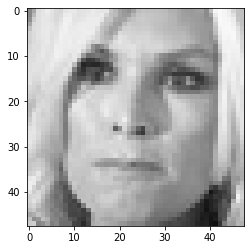

In [8]:
image = cv2.imread('./train/0/Training_33331.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
print('Shape : ', image.shape)

# Resizing Image

Shape :  (224, 224, 3)


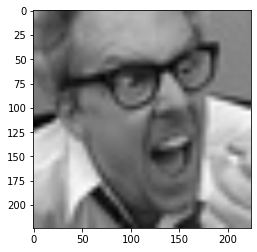

In [5]:
images_resized = cv2.resize(image, (224, 224))
plt.imshow(images_resized)
print('Shape : ', images_resized.shape)

# Create Training Data

In [23]:
emotion_dict = {0 : "angry", 1 : "disgust", 2 : "fear", 3 : "happy", 4 : "neutral", 
                5 : "sad", 6 : "surprise"}
classes = list(emotion_dict.keys())
print(classes)

[0, 1, 2, 3, 4, 5, 6]


In [6]:
def create_training_data():
    training_data = []
    data_dir = './train'
    for category in classes:
        path = os.path.join(data_dir, str(category))
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
                image = cv2.imread(os.path.join(path, img))
                image_resized = cv2.resize(image, (224, 224))
                training_data.append([image_resized, class_num])
            except Exception as e:
                pass
    return training_data

In [7]:
training_data = create_training_data()

# Shuffling the Dataset

In [9]:
random.shuffle(training_data)

In [10]:
X_train_orig = []
y_train_orig = []

for features, label in training_data:
    X_train_orig.append(features)
    y_train_orig.append(label)

X_train_orig = np.array(X_train_orig)
y_train_orig = np.array(y_train_orig)
X_train_orig = X_train_orig / 255.0 # Normalizing the data

# Saving the Training Data

In [11]:
np.save('X_train_original', X_train_orig)
np.save('y_train_original', y_train_orig)

# Loading the Training Data

In [7]:
X_train_orig = np.load('./Train_Data/X_train_original.npy')
y_train_orig = np.load('./Train_Data/y_train_original.npy')

In [20]:
print(X_train_orig.shape, y_train_orig.shape)
X_train = X_train_orig[:1000]
y_train = y_train_orig[:1000]
print('X_train : ', X_train.shape)
print('y_train : ', y_train.shape)

(28709, 224, 224, 3) (28709,)
X_train :  (1000, 224, 224, 3)
y_train :  (1000,)


# Using MobileNet Pretrained Model

In [9]:
tf.keras.backend.clear_session()
model = tf.keras.applications.MobileNetV2()

In [8]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

# Transfer Learning

In [10]:
base_input = model.layers[0].input
base_output = model.layers[-2].output
print(base_input)
print(base_output)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 1280), dtype=tf.float32, name=None), name='global_average_pooling2d/MLCGlobalAvgPool2D:0', description="created by layer 'global_average_pooling2d'")


In [11]:
final_output = tf.keras.layers.Dense(128)(base_output)
final_output = tf.keras.layers.Activation('relu')(final_output)
final_output = tf.keras.layers.Dense(64)(final_output)
final_output = tf.keras.layers.Activation('relu')(final_output)
final_output = tf.keras.layers.Dense(64)(final_output)
final_output = tf.keras.layers.Activation('relu')(final_output)
final_output = tf.keras.layers.Dense(7, activation='softmax')(final_output)

In [12]:
new_model = tf.keras.Model(inputs=base_input, outputs=final_output)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [8]:
lower_limit = 15000
size=1000
X_train = X_train_orig[lower_limit:lower_limit+size]
y_train = y_train_orig[lower_limit:lower_limit+size]
print(X_train.shape)
print(y_train.shape)

(1000, 224, 224, 3)
(1000,)


In [16]:
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(X_train.shape)
print(y_train.shape)
print(new_model.layers[0].input)

(5000, 224, 224, 3)
(5000,)
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


In [17]:
new_model.fit(X_train, y_train, epochs=25)

2021-10-28 13:18:49.117427: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-28 13:18:49.197595: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
157/157 [==============================] - 284s 2s/step - loss: 1.5862 - accuracy: 0.3849
Epoch 2/25
157/157 [==============================] - 252s 2s/step - loss: 1.2759 - accuracy: 0.5109
Epoch 3/25
157/157 [==============================] - 293s 2s/step - loss: 1.1331 - accuracy: 0.5868
Epoch 4/25
157/157 [==============================] - 291s 2s/s

In [21]:
new_model.save("my_model_h5.h5")

# Loading Back The Model

In [9]:
new_model = tf.keras.models.load_model("./my_model_h5.h5")
#new_model.summary()

In [13]:
lower_limit = 15000
size=1000
X_train = X_train_orig[lower_limit:lower_limit+size]
y_train = y_train_orig[lower_limit:lower_limit+size]
print(X_train.shape)
print(y_train.shape)

(1000, 224, 224, 3)
(1000,)


In [14]:
new_model.fit(X_train, y_train, epochs=1, batch_size=32)
new_model.save("./my_model_h5.h5")

32/32 [==============================] - 44s 1s/step - loss: 1.4929 - accuracy: 0.5250


In [3]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
def detect_face(image):
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        image_gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(224, 224)
    )
    for x, y, w, h in faces:
        face = image[y:y+h, x:x+w]
    face = cv2.resize(face, (224, 224))
    return cv2.cvtColor(face, cv2.COLOR_BGR2RGB)


In [ ]:
image = cv2.imread('./images/saket2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = detect_face(image)
# #

#image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV).astype("float32")
#image = cv2.cvtColor(image.astype("uint8"), cv2.COLOR_HSV2BGR)
#
image = cv2.resize(image, (224, 224))
image = np.array(image)
plt.subplot(1, 3, 1) # row 1, col 2 index 1
plt.imshow(image)
image = np.expand_dims(image, axis=0)
image = image / 255.0
print(image.shape)
predictions = new_model.predict(image)

plt.subplot(1, 2, 2) # index 2
plt.barh(list(emotion_dict.values()), predictions[0])
plt.show()
# print(predictions)
# print(emotion_dict[np.argmax(predictions)])

In [57]:
print(emotion_dict)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


# Applying the Model on Streaming Data from WebCam

In [ ]:
image = cv2.imread('./images/saket.png')
image = detect_face(image)
plt.imshow(image)

In [8]:
new_model = tf.keras.models.load_model("./SAVED_MODELS/1st.h5")
# new_model = tf.keras.models.load_model("./my_model_h5.h5")


emotion_dict = {0 : "angry", 1 : "disgust", 2 : "fear", 3 : "happy", 4 : "neutral", 
                5 : "sad", 6 : "surprise"}
emotion_color = {0 : (0, 0, 255), 1 : (0, 95, 115), 2 : (202, 103, 2), 3 : (0, 255, 0), 4 : (244, 162, 97), 
                5 : (0 ,0, 0), 6 : (233, 196, 106)}

video_capture = cv2.VideoCapture(0)
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

while True:
    # For WebCam
    ret, frame = video_capture.read()

    # For Screen Recording
    # frame = pyautogui.screenshot()
    # frame = np.array(frame)

    image_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(
        image_gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(224, 224)
    )
    for x, y, w, h in faces:
        face = frame[y:y+h, x:x+w]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        # face = cv2.cvtColor(face, cv2.COLOR_BGR2HSV).astype("float32")
        # face = cv2.cvtColor(face.astype("uint8"), cv2.COLOR_HSV2BGR)
        face = cv2.resize(face, (224, 224))
        face = np.expand_dims(face, axis=0) / 255.0
        out = new_model.predict(face)
        out = np.argmax(out)
        emo = emotion_dict[out]
        cv2.rectangle(frame, (x, y), (x+w, y+h), emotion_color[out], 2)
        cv2.putText(frame, emo, (x + int(w/10), y - int(h/15)), cv2.FONT_HERSHEY_SIMPLEX, 1, emotion_color[out], cv2.LINE_4)

    
    cv2.imshow('Output', frame)
    if cv2.waitKey(2) & 0xFF == ord('q'):
        break
cv2.destroyWindow('Output')
cv2.waitKey(1)
video_capture.release()
    



    

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [3]:
video_capture.release()
cv2.destroyWindow('Output')
cv2.waitKey(1)


-1

In [ ]:
lower_limit = 10000
size=1000
X_train = X_train_orig[lower_limit:lower_limit+size]
y_train = y_train_orig[lower_limit:lower_limit+size]
print(X_train.shape)
print(y_train.shape)

# Using Efficient Net Model

In [6]:
tf.keras.backend.clear_session()
efficientNet = tf.keras.applications.EfficientNetB0()

base_input = efficientNet.layers[0].input
base_output = efficientNet.layers[-2].output
# print(base_input)
# print(base_output)

final_output = tf.keras.layers.Dense(128)(base_output)
final_output = tf.keras.layers.Activation(activation='relu')(final_output)
final_output = tf.keras.layers.Dense(64)(final_output)
final_output = tf.keras.layers.Activation(activation='relu')(final_output)
final_output = tf.keras.layers.Dense(7, activation='softmax')(final_output)

tf.keras.backend.clear_session()
efficientNet = tf.keras.Model(inputs=base_input, outputs=final_output)
# efficientNet.summary()

In [7]:
efficientNet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
lower_limit = 8000
size=500
X_train = X_train_orig[lower_limit:lower_limit+size]
y_train = y_train_orig[lower_limit:lower_limit+size]
print(X_train.shape)
print(y_train.shape)

(500, 224, 224, 3)
(500,)


In [9]:
efficientNet.fit(X_train, y_train, epochs=5)

Epoch 1/5
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2021-10-27 15:59:34.126733: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-27 15:59:34.131182: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


16/16 [==============================] - 806s 52s/step - loss: 1.8761 - accuracy: 0.2593
Epoch 2/5
16/16 [==============================] - 726s 46s/step - loss: 1.4254 - accuracy: 0.4951
Epoch 3/5
 1/16 [>.............................] - ETA: 8:51 - loss: 1.0551 - accuracy: 0.6250